## Описание задачи
Рассмотрим классический слот, имеющий 5 барабанов и игровое поле 5x3. На барабанах
встречаются символы A, B, C, D, E, F, G, H, а также символ W (вайлд) и S (фри-спин).
Барабаны вращаются независимо друг от друга, все положения каждого из барабанов
равновероятны.
Выигрышными считаются комбинации содержащие 3 и более одинаковых символа вдоль
выигрышной линии, начиная с самого левого символа на линии, или начиная с самого
правого символа на линии. Символ W (вайлд) может заменять любой символ при
формировании выигрышной комбинации.

На всех барабанах кроме крайних расположены следующие символы:
GSEDGDBWGFEAHGBCHCBFACGGEFSCAWAHEFDWCGEEGFFGHDCHGBGCHCBHDD
DBFHSWHSADCHABCDSEHBDADAEFDHGCEHDSFCAAFCHCBAFDGEFDGBECBSFEC
WSFWFEBHCDHGGGSGBHGFAHAAAFCFHBADAWDBWEBAEAEBFCWBDWCBFHESDE
EBEAG

На крайних барабанах удалены символы W (вайлд), остальные символы те же.

Линии выплат:
Таблица выплат:
A B C D E F G H
3 символа 4 3 2 1 0.4 0.3 0.2 0.1
4 символа 20 15 10 5 2 1.5 1 0.5
5 символов 40 30 20 10 4 3 2 1

При выпадении на поле 3-х и более символов S (фри-спинов) начисляются дополнительные
вращения барабанов, в течении которых могут выпадать дополнительные выигрышные
комбинации и фри-спины. 
Количество начисляемых фри-спинов следующим образом зависит
от количества символов S:
3 символа – 5 фри-спинов, 4 символа – 10 фри-спинов, 5 символов – 15 фри-спинов.

Раунд состоит из начального вращения и всех последующих за ним фри-спинов.

**Задача:** найти матожидание и дисперсию величины X – суммарного выигрыша в раунде.
Укажите погрешность, доверительный интервал для этих значений или сделайте оценку, если
не можете найти точные значения.
Если для нахождения матожидания и дисперсии X нужно сделать дополнительные
предположения, то сформулируйте их в явном виде.



## Аннотация к решению: 
Используется метод Монте Карло для генерации выборки случайной величины суммы выигрыша. 

**Описание алгоритма:**
Генерируется 5 случайных величин - номера элементов положений середин барабанов. На основе этих чисел формируется матрица с результатами игры. По матрице вычисляется выигрыш и доступные спины. Алгоритм повторяется и выигрыш суммируется до тех пор, пока есть доступные спины. Так как положения каждого из барабанов равновероятны, то используется генератор случайной величины с равномерной функцией распределения.


Доверительные интервалы для дисперсии и мат ожидания вычисляются по формулам [[Ссылка 1]](https://mse.msu.ru/wp-content/uploads/2020/03/%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F-5-%D0%B4%D0%BE%D0%B2%D0%B5%D1%80%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D0%B2%D0%B0%D0%BB%D1%8B.pdf), [[Ссылка 2]](https://aegis4048.github.io/comprehensive_confidence_intervals_for_python_developers) в предположении что генеральная совокупность имеет нормальную форму.

**Результат:**
В результате реализации, проведены симуляции 10^4, 10^5, 10^6 игр. 
Проведен расчет мат ожидания, дисперсии и доверительные интервалов этих величин. Приведен график распределения игр с ненулевым выигрышем.



------------------------------------------------------------------------------------------


In [32]:
#Remove warnings
import warnings
warnings.simplefilter("ignore")
#Basic data analysis libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import math
import random

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

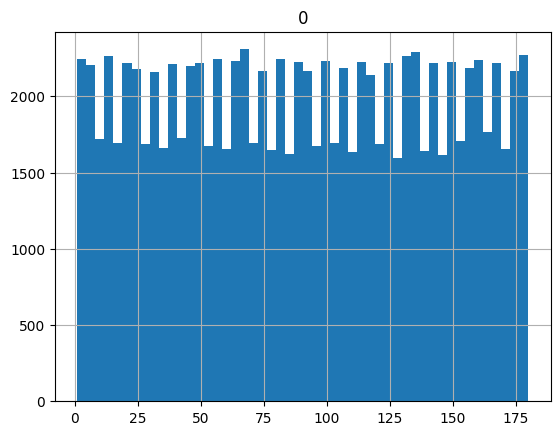

In [33]:
# Визуально проверим "равномерность" генератора
N_Games = 100000
tmp = []

for i in range(1, N_Games):
    tmp.append(random.randint(1, 180))
    
df = pd.DataFrame(tmp)
df.hist(bins=50)

In [34]:
#Параметры барабанов

#Лента центральных барабанов 
BarabanStringCenter = 'GSEDGDBWGFEAHGBCHCBFACGGEFSCAWAHEFDWCGEEGFFGHDCHGBGCHCBHDDDBFHSWHSADCHABCDSEHBDADAEFDHGCEHDSFCAAFCHCBAFDGEFDGBECBSFECWSFWFEBHCDHGGGSGBHGFAHAAAFCFHBADAWDBWEBAEAEBFCWBDWCBFHESDEEBEAG'
#Лента барабанов на краях
BarabanStringBoundary = BarabanStringCenter.replace('W', '')

# Получение матрицы 5х3 результата игры
def GameMatrixResult(S1, S2, S3, S4, S5): 
    # Подставляем входные параметры в положения массивов BarabanStringCenter и BarabanStringBoundary
    arr = [[BarabanStringBoundary[S1-1], BarabanStringCenter[S2-1], BarabanStringCenter[S3-1], BarabanStringCenter[S4-1], BarabanStringBoundary[S5-1]], 
           [BarabanStringBoundary[S1], BarabanStringCenter[S2], BarabanStringCenter[S3], BarabanStringCenter[S4], BarabanStringBoundary[S5]], 
           [BarabanStringBoundary[S1+1], BarabanStringCenter[S2+1], BarabanStringCenter[S3+1], BarabanStringCenter[S4+1], BarabanStringBoundary[S5+1]]]
    arr = np.array(arr)
    return(arr)

N_BarabanStringCenter = len(BarabanStringCenter)-1
N_BarabanStringBoundary = len(BarabanStringBoundary)-1

tmp = GameMatrixResult(1, 1, 1, 1, 1)

print('Пример одной реализации игры \n' + str(tmp))

Пример одной реализации игры 
[['G' 'G' 'G' 'G' 'G']
 ['S' 'S' 'S' 'S' 'S']
 ['E' 'E' 'E' 'E' 'E']]


In [35]:
add_spin3 = 5
add_spin4 = 10
add_spin5 = 15

def PrizeResult(MatrixResult):
    PrizeValue = 0
    add_spin = 0

    # По таблице выплат считаем выигрыш по всем линиям выплат
    # 9 линий выплат
    lines = []

    lines.append(MatrixResult[0, 0]+MatrixResult[0, 1]+MatrixResult[0, 2]+MatrixResult[0, 3]+MatrixResult[0, 4])
    lines.append(MatrixResult[1, 0]+MatrixResult[1, 1]+MatrixResult[1, 2]+MatrixResult[1, 3]+MatrixResult[1, 4])
    lines.append(MatrixResult[2, 0]+MatrixResult[2, 1]+MatrixResult[2, 2]+MatrixResult[2, 3]+MatrixResult[2, 4])

    lines.append(MatrixResult[0, 0]+MatrixResult[1, 1]+MatrixResult[2, 2]+MatrixResult[1, 3]+MatrixResult[0, 4])
    lines.append(MatrixResult[2, 0]+MatrixResult[1, 1]+MatrixResult[0, 2]+MatrixResult[1, 3]+MatrixResult[2, 4])
    lines.append(MatrixResult[0, 0]+MatrixResult[1, 1]+MatrixResult[1, 2]+MatrixResult[1, 3]+MatrixResult[0, 4])

    lines.append(MatrixResult[2, 0]+MatrixResult[1, 1]+MatrixResult[1, 2]+MatrixResult[1, 3]+MatrixResult[2, 4])
    lines.append(MatrixResult[0, 0]+MatrixResult[0, 1]+MatrixResult[1, 2]+MatrixResult[2, 3]+MatrixResult[2, 4])
    lines.append(MatrixResult[2, 0]+MatrixResult[2, 1]+MatrixResult[1, 2]+MatrixResult[0, 3]+MatrixResult[0, 4])
    #print(lines)
    

    d = {'AAAAA': 40,'AAAA': 20,'AAA': 4,   
         'BBBBB': 30, 'BBBB': 15,'BBB': 3,  
        'CCCCC': 20, 'CCCC': 10, 'CCC': 2,  
        'DDDDD': 10, 'DDDD': 5, 'DDD': 1, 
        'EEEEE': 4, 'EEEE': 2, 'EEE': 0.4,  
        'FFFFF': 3, 'FFFF': 1.5, 'FFF': 0.3, 
        'GGGGG': 2, 'GGGG': 1, 'GGG': 0.2, 
        'HHHHH': 1, 'HHHH': 0.5,'HHH': 0.1}

    #ищем шаблоны по ключам словаря
    for i in lines: 
        for j in list(d.keys()):   
            if i.find(j)!=-1:
                PrizeValue = PrizeValue + d[j]               
                #print(d[j])
                break
       
    # В зависимости от числа элементов S в матрице выберем число спинов
    # 3 символа – 5 фри-спинов, 4 символа – 10 фри-спинов, 5 символов – 15 фри-спинов  
    num_of_S = len(np.where(MatrixResult=='S')[0])
    if num_of_S == 3:
        add_spin = 5
    if num_of_S == 4:
        add_spin = 10
    if num_of_S >= 5:
        add_spin = 15        
    
    return PrizeValue, add_spin


print('Пример расчета размера приза по всем 9 линиям выплат и числа фриспинов за 1 вращение \n' )
print('Матрица игры \n' + str(tmp))      
print('Сумма выигрыша \n' + str(PrizeResult(tmp)[0])) 
print('Число начисленных фриспинов за раунд \n' + str(PrizeResult(tmp)[1])) 

Пример расчета размера приза по всем 9 линиям выплат и числа фриспинов за 1 вращение 

Матрица игры 
[['G' 'G' 'G' 'G' 'G']
 ['S' 'S' 'S' 'S' 'S']
 ['E' 'E' 'E' 'E' 'E']]
Сумма выигрыша 
6
Число начисленных фриспинов за раунд 
15


In [36]:
from scipy import stats
# Блок симуляции игры (Game Simulation - название функции)
N_Games = [10000, 100000, 1000000]
X = []

for m in N_Games:
    for i in range(1, m):
        available_num_spin = 1
        PrizeValuePerGame = 0
        # Пока число доступных прокруток >1
        k = 0 #счетчик игр
        while available_num_spin > 0:
            # Генерируется 5 случайных чисел: 3 от 1 до N_BarabanStringCenter, 2 от 1 до N_BarabanStringBoundary
            Baraban_1 = random.randint(1, N_BarabanStringBoundary-1)
            Baraban_2 = random.randint(1, N_BarabanStringCenter-1)
            Baraban_3 = random.randint(1, N_BarabanStringCenter-1)
            Baraban_4 = random.randint(1, N_BarabanStringCenter-1)
            Baraban_5 = random.randint(1, N_BarabanStringBoundary-1)

            MatrixOfGame = GameMatrixResult(Baraban_1, Baraban_2, Baraban_3, Baraban_4, Baraban_5)
            PrizeValuePerSpin, add_spin = PrizeResult(MatrixOfGame)        
            available_num_spin = available_num_spin - 1 + add_spin
            PrizeValuePerGame = PrizeValuePerGame + PrizeValuePerSpin
            k = k + 1
        #print('Игра номер '+str(i) + ' Выигрыш ' + str(PrizeValuePerGame) + ' Число оборотов ' + str(k))
        X.append(PrizeValuePerGame)
                
    df = pd.DataFrame(X, columns =['Выигрыш за 1 игру']) 
    alpha = 0.05                       # significance level = 5%
    t = stats.t.ppf(1 - alpha/2, m-1)   # t-critical value for 95% CI = 2.093
    
    tmp = df['Выигрыш за 1 игру'].mean()*t/math.sqrt(m)
    leftmean_confidence_interval = df['Выигрыш за 1 игру'].mean()-tmp
    rightmean_confidence_interval = df['Выигрыш за 1 игру'].mean()+tmp
  
    alpha = 0.05  # significance level = 5%
    s2 = df['Выигрыш за 1 игру'].var()   # sample variance
    leftvar_confidence_interval = (m - 1) * s2 / stats.chi2.ppf(alpha / 2, m - 1)
    rightvar_confidence_interval = (m - 1) * s2 / stats.chi2.ppf(1 - alpha / 2, m - 1)
     
    print('Число генерируемых игр N='+str(m))
    print('Выборочное среднее ' + str(df['Выигрыш за 1 игру'].mean()))
    print('Левая граница 95%  доверительного интервала среднего ' + str(leftmean_confidence_interval))
    print('Правая граница 95% доверительного интервала  среднего ' + str(rightmean_confidence_interval)) 
    
    print('Выборочная дисперсия ' + str(df['Выигрыш за 1 игру'].var()))
    print('Левая граница 95% доверительного интервала дисперсии ' + str(leftvar_confidence_interval))
    print('Правая граница 95% доверительного интервала дисперсии ' + str(rightvar_confidence_interval)) 

    #print('Медиана ' + str(df['Выигрыш за 1 игру'].median()))
        
  

Число генерируемых игр N=10000
Выборочное среднее 0.6166616661666173
Левая граница 95%  доверительного интервала среднего 0.6045738563941507
Правая граница 95% доверительного интервала  среднего 0.6287494759390839
Выборочная дисперсия 5.57873416347481
Левая граница 95% доверительного интервала дисперсии 5.736661761236303
Правая граница 95% доверительного интервала дисперсии 5.4272676819881545
Число генерируемых игр N=100000
Выборочное среднее 0.6746077201403782
Левая граница 95%  доверительного интервала среднего 0.6704264843947076
Правая граница 95% доверительного интервала  среднего 0.6787889558860487
Выборочная дисперсия 7.224620369865694
Левая граница 95% доверительного интервала дисперсии 7.288366688914616
Правая граница 95% доверительного интервала дисперсии 7.161710493515802
Число генерируемых игр N=1000000
Выборочное среднее 0.6793081422742708
Левая граница 95%  доверительного интервала среднего 0.6779767211695018
Правая граница 95% доверительного интервала  среднего 0.68063956

Таким образом мат. ожидание равно примерно 0.67, дисперсия лежит в интервале от 7 до 7.3

<AxesSubplot: >

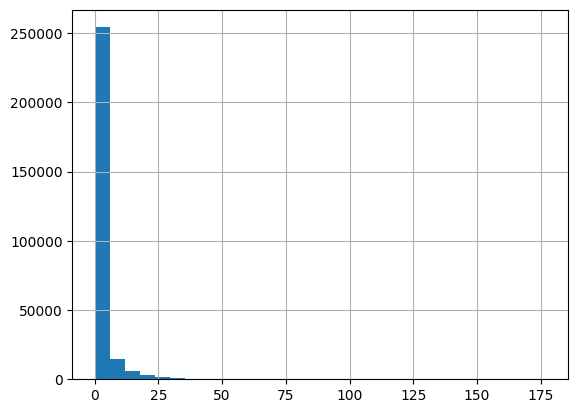

In [37]:
#распределение ненулевых выигрышей
df_tmp = df['Выигрыш за 1 игру'][df['Выигрыш за 1 игру']>0.01]
display(df_tmp[df['Выигрыш за 1 игру']<1000].hist(bins=30))  

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Выигрыш за 1 игру,1109997.0,0.679308,2.669005,0.0,0.0,0.0,0.1,177.0


## Учет дисбаланса распределения

### Преобразование Box-Cox

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# generate non-normal sample
x = df['Выигрыш за 1 игру'][df['Выигрыш за 1 игру']>0]

# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(x)
stats.probplot(x, dist=stats.norm, plot=axes[1])
fig.tight_layout()

# summary statistics
df1 = pd.DataFrame(x).describe().T
df1['Median'] = np.median(x)
df1

,count,mean,std,min,25%,50%,75%,max,Median
Выигрыш за 1 игру,280868.0,2.684642,4.771691,0.1,0.3,1.0,3.0,177.0,1.0


,count,mean,std,min,25%,50%,75%,max,Median
0,279943.0,0.072522,1.41838,-2.288499,-1.200114,0.0,1.101838,4.915379,0.0


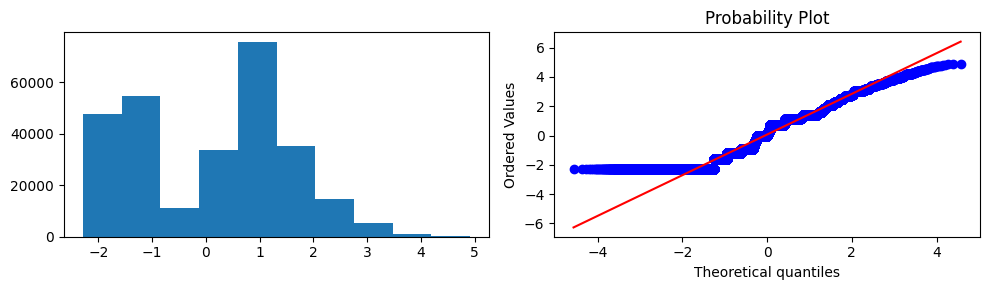

In [27]:
xt, lmbda = stats.boxcox(x)
# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(xt)
stats.probplot(xt, dist=stats.norm, plot=axes[1])
fig.tight_layout()

# summary statistics
df1 = pd.DataFrame(xt).describe().T
df1['Median'] = np.median(xt)
df1

Преобразование не дает существенного приближения к нормальному закону даже если удалить нули

### Bootstrap

In [31]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

# simulation settings
NUM_SAMPLES = 1000
SAMPLE_SIZE = 100
BOOT_SAMPLE_SIZE = 100

# analytical confidence interval of mean
def ci_mean_analytic(arr, alpha):
    return stats.t.interval(1 - alpha, len(arr) - 1, loc=np.mean(arr), scale=stats.sem(arr))

# bootstrap confidence interval of mean
def ci_mean_boot(arr, p_lo, p_hi, r=BOOT_SAMPLE_SIZE):
    boot_var = [np.mean(np.random.choice(arr, len(arr))) for _ in range(r)]
    lo = np.percentile(boot_var, p_lo)
    hi = np.percentile(boot_var, p_hi)
    return (lo, hi)

# analytical confidence interval of variance
def ci_var_analytic(arr, alpha):
    lo, hi = (
        (len(arr) - 1) * np.var(arr, ddof=1) / stats.chi2.ppf(1 - alpha / 2, len(arr) - 1),
        (len(arr) - 1) * np.var(arr, ddof=1) / stats.chi2.ppf(alpha / 2, len(arr) - 1)
    )
    return (lo, hi)

# bootstrap confidence interval of variance
def ci_var_boot(arr, p_lo, p_hi, r=BOOT_SAMPLE_SIZE):
    boot_var = [np.var(np.random.choice(arr, len(arr)), ddof=1) for _ in range(r)]
    lo = np.percentile(boot_var, p_lo)
    hi = np.percentile(boot_var, p_hi)
    return (lo, hi)

# check if the confidence interval includes the population parameter
def coverage_test(lo, hi, target):
    if lo <= target <= hi:
        return 1
    else:
        return 0

# define population
pop = df['Выигрыш за 1 игру']
# population mean
mean_pop = np.mean(pop)
# population variance
var_pop = np.var(pop, ddof=0)

# initialize
count_mean_norm_analytic, count_mean_analytic, count_mean_skew_analytic, count_mean_lognorm_analytic = [], [], [], []
count_mean_norm_boot, count_mean_boot, count_mean_skew_boot, count_mean_lognorm_boot = [], [], [], []
count_var_norm_analytic, count_var_analytic, count_var_skew_analytic, count_var_lognorm_analytic = [], [], [], []
count_var_norm_boot, count_var_boot, count_var_skew_boot, count_var_lognorm_boot = [], [], [], []

for i in range(NUM_SAMPLES):
    # randomly draw samples from population
    samp = np.random.choice(pop, SAMPLE_SIZE)
    # 95% ANALYTICAL confidence interval of MEAN
    mean_lo_analytic, mean_hi_analytic = ci_mean_analytic(samp, 0.05)
    # 95% BOOTSTRAP confidence interval of MEAN
    mean_lo_boot, mean_hi_boot = ci_mean_boot(samp, 2.5, 97.5)
    # 95% ANALYTICAL confidence interval of VARIANCE
    var_lo_analytic, var_hi_analytic = ci_var_analytic(samp, 0.05)
    # 95% BOOSTRAP confidence interval of VARIANCE
    var_lo_boot, var_hi_boot = ci_var_boot(samp, 2.5, 97.5)

    # coverage test for ANALYTICAL CI of MEAN
    count_mean_analytic.append(coverage_test(mean_lo_analytic, mean_hi_analytic, mean_pop))
    # coverage test for BOOTSTRAP CI of MEAN
    count_mean_boot.append(coverage_test(mean_lo_boot, mean_hi_boot, mean_pop))
    # coverage test for ANALYTICAL CI of VARIANCE
    count_var_analytic.append(coverage_test(var_lo_analytic, var_hi_analytic, var_pop))
    # coverage test for BOOTSTRAP CI of VARIANCE
    count_var_boot.append(coverage_test(var_lo_boot, var_hi_boot, var_pop))

    
print()
print('###########################################################')
print('                     Coverage Test (%)                     ')
print('###########################################################')
print()
print()
#print('------------------ Parametric CI of mean ------------------')
#print()
#print('{:<40}  {:>15} %'.format(' ', round(sum(count_mean_analytic) / NUM_SAMPLES * 100, 1)))
#print()
print('------------------ Non-parametric CI of mean --------------')
print()
print('{:<40}  {:>15} %'.format(' ', round(sum(count_mean_boot) / NUM_SAMPLES * 100, 1)))
print()
#print('---------------- Parametric CI of variance ----------------')
#print()
#print('{:<40}  {:>15} %'.format(' ', round(sum(count_var_analytic) / NUM_SAMPLES * 100, 1)))
print()
print('---------------- Non-parametric CI of variance ------------')
print()
print('{:<40}  {:>15} %'.format(' ', round(sum(count_var_boot) / NUM_SAMPLES * 100, 1)))



###########################################################
                     Coverage Test (%)                     
###########################################################


------------------ Non-parametric CI of mean --------------

                                                     83.3 %


---------------- Non-parametric CI of variance ------------

                                                     58.5 %
